# Notebook to demonstrate $k$-means selection criteria.
### MSP, 13 Nov 2016

#### updated for inclusion to exptool/tests on 30 Dec 2017

#### converted to polar trapping 26 Jun 2018

#### added analysis at scale 15 Nov 2019

#### re-tested 3 Nov 2021, added some comments.

This notebook walks through the selection criteria for computing trapping, including __Part 1: Selecting Family Criteria__, __Part 2: Tracking Families through Time__, and __Part 3: Analyzing Simulations at Scale__. At the end, an _Appendix_ demonstrates the principles exploited and provides a number of alternate examples.

The data for this notebook is self-contained and ships with _exptool_.

In [1]:
# standard python modules
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline
import time
import scipy.interpolate as interpolate



In [2]:
# exptool classes
from exptool.analysis import trapping
from exptool.utils import kmeans
from exptool.io import psp_io
from exptool.utils import kde_3d
from exptool.analysis import pattern
from exptool.utils import utils
from exptool.utils import *


import exptool
import pkg_resources



In [3]:
# change some plotting parameters
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.serif'] = 'Helvetica'
mpl.rcParams['font.weight'] = 'medium'

mpl.rcParams['axes.linewidth'] = 1.0
mpl.rcParams['xtick.major.width'] = 1.0
mpl.rcParams['xtick.minor.width'] = 0.5
mpl.rcParams['xtick.minor.visible'] = True

mpl.rcParams['ytick.major.width'] = 1.0
mpl.rcParams['ytick.minor.width'] = 0.5
mpl.rcParams['ytick.minor.visible'] = True

mpl.rcParams['figure.figsize'] = (5,3.5)
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['axes.labelsize'] = 12

## Part 0: Simulation Introduction

Using example files from exptool, explore trapping metrics in a simulation.

In [4]:
bar_file = pkg_resources.resource_filename('exptool', 'tests/barfile001.dat')
aps_file = pkg_resources.resource_filename('exptool', 'tests/aps_example.dat')



In [5]:
# read in the bar file
BarInstance = pattern.BarDetermine()
BarInstance.read_bar(bar_file)

Check the period of the bar; may want to use as an adaptive criteria for aps timing threshold (see below).

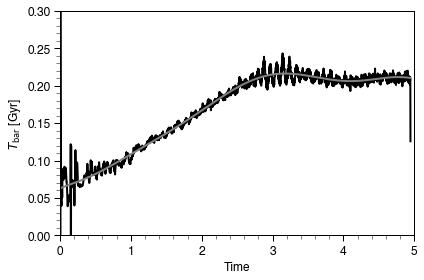

In [6]:
Bardiff = np.ediff1d(BarInstance.pos,to_end=0.1)


fig = plt.figure(figsize=(6,4))

plt.plot(BarInstance.time,(2.*np.pi)/(Bardiff/0.002),color='black')
plt.xlabel('Time')
plt.ylabel('$T_{\\rm bar}$ [Gyr]')
_ = plt.axis([0.0,5.0,0.0,0.3])

bar_period = np.polyfit(BarInstance.time[10:-10],(2.*np.pi)/(Bardiff[10:-10]/0.002),9)
bar_period_func = np.poly1d(bar_period)

_ = plt.plot(BarInstance.time,bar_period_func(BarInstance.time),color='gray')

fig.tight_layout()
plt.savefig('../figures/bar_period.png')


## Part 1: Defining Trapping

Now read in a file of aps, processed using trapping.ApsFinding() previously.

In [7]:
def _read_aps_file(aps_file):
        """read in an aps file

        This is a temporary override to be compatibile with an older fileformat -- typically one would use
        ApsFinding.read_aps_file(aps_file), as indicated below.

        """

        f = open(aps_file,'rb')

        [desc] = np.fromfile(f,dtype='S200',count=1)

        [norb] = np.fromfile(f,dtype='i',count=1)

        ApsDict = dict()

        #indx_array = []

        for i in range(norb):

            #[indx] = np.fromfile(f,dtype='i',count=1)
            #indx_array.append(indx)
            
            [naps] = np.fromfile(f,dtype='i',count=1)

            
            if naps > 0:
    
                aps_array = np.fromfile(f,dtype='f',count=4*naps)
                
                ApsDict[i] = aps_array.reshape([naps,4])


        f.close()

        #ApsDict = dict()
        
        #for indx in range(0,norb):
        #    ApsDict[indx] = aps[indx]
            
        ApsDict['desc']  = desc
        ApsDict['norb']  = norb
        #ApsDict['index'] = np.array(indx_array)

        return ApsDict

In [8]:
A = trapping.ApsFinding()
#TrappingInstance = A.read_aps_file(aps_file)
TrappingInstance = _read_aps_file(aps_file)
print(TrappingInstance['desc'])

norb = TrappingInstance['norb']

b'apsfile for star in /scratch/mpetersen/Disk001/, norbits=1000, threedee=False, using /scratch/mpetersen/Disk001/simfiles.dat'


### Theoretical Considerations

Calculate quantities for each orbit. Given a set of aps, find:

0. $\langle \theta_{\rm bar}\rangle_N$, the standard trapping metric that assesses the angular separation from the bar for the clusters. Returned value is the maximum angular separation from the bar for the two clusters. $N$ is the number of aps to use in the average.
1. $\langle X_{\rm aps}\rangle_N$, the average position along the bar axis of the aps, by cluster. Then take the minimum of this value. That is, this is the smallest extent of the aps when clustered.
2. $\sigma_{X_{\rm aps}}$, the variance along the bar major axis of the aps positions in a given cluster (and corresponding $Y$ value).
3. Using the ratio of (1) and (2) as a S/N proxy; $x_1$ orbits, as well as higher-order families, have large values. Note that to find $x_2$ orbits, do (1) and (2) in the y-dimension.
4. $\Omega_r$, the $r$ dimension frequency. Used to calculate orbits that fall below the Nyquist frequency for time sampling.

Two improvements over PWK16:
1. Use the closest $N$ aps in time to the indexed time
2. Set a threshold, $T_{\rm thresh}$, that is some multiple of the bar period $T_{\rm bar}$ in which the $N$ aps must reside.

Some combination of these quantities will define the bar.

### In practice, single timestep

Use a smattering of metrics to discern the structure of the bar at late times for a given model:

1. A demonstration of the technique used in PWK16: using $\langle \theta_{\rm bar}\rangle_N$ and $\Omega_r$ to define a region of interest.
2. Moving beyond PWK16: using $\sigma(|X_{\rm aps}|)$ and $\sigma(|Y_{\rm aps}|)$ to examine regions of interest for different orbital families.
3. Now, we want to use $\langle \theta_{\rm bar}\rangle_N$ and $\sigma_{X_{\rm aps}}$ to define the bar. That is, find the particles who linger near the bar and do not disperse too far along the bar axis.

This is a tool to help discern what the cutoffs should be for a given model.

Step 1: Compute the trapping quantities for the orbits at a selected (late) time.

In [9]:
# set the basic trapping parameters here
desired_time = 2.5     # what simulation time to calculate trapping
N = 20                 # how many closest aps?
t_thresh = 1.5         # threshold cutoff for what aps must be inside?


Now do the computation, using a wrapper function from exptool.trapping.

In [10]:
theta_20,r_frequency,x_position,sigma_x,sigma_y = \
trapping.do_single_kmeans_step(TrappingInstance,BarInstance,desired_time,\
                          sbuffer=N,\
                          t_thresh=t_thresh,\
                          maxima=False,\
                          verbose=1,\
                              mad=False,\
                              k=2,\
                               polar=True)#,rank=True,perc=90.)

skipped_for_aps 91_kmeans_step: [=================== ] 99%
skipped_for_res 326
sent_to_kmeans_plus 2
failed_kmeans_plus 0


### Three Visualizations of Criteria

#### --- 1 ---
A demonstration of the technique used in PWK16: using $\langle \theta_{\rm bar}\rangle_N$ and $\Omega_r$ to define a region of interest.

(The shaded region highlights the chosen cutoffs)

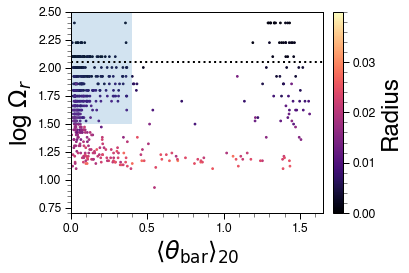

In [11]:
fig = plt.figure(figsize=(7,4))

ax1 = fig.add_axes([0.20,0.24,0.5,0.7]) # main axis
ax2 = fig.add_axes([0.72,0.24,0.02,0.7]) # colorbar

clrs = cm.magma


cpalette = np.linspace(0.,0.04,100)
ax1.scatter(theta_20,np.log10(r_frequency),color=cm.magma( (x_position-np.min(cpalette))/(np.max(cpalette)),1.),s=3.,)
ax1.axis([0.,1.65,0.7,2.5])

ax1.fill_between([0.0,0.4],[1.5,1.5],[2.5,2.5],alpha=0.2,edgecolor='None')
ax1.plot([0.0,1.65],[2.05,2.05],color='black',linestyle='dotted') #nyquist




ax1.set_xlabel('$\\langle \\theta_{\\rm bar} \\rangle_{20}$',size=24)
ax1.set_ylabel('log $\Omega_r$',size=24)
norm = mpl.colors.Normalize(vmin=np.min(cpalette), vmax=np.max(cpalette))
cb1 = mpl.colorbar.ColorbarBase(ax2, cmap=clrs,norm=norm)
cb1.set_label('Radius',size=24)
cb1.set_ticks([0.0,0.01,0.02,0.03])



plt.savefig('../figures/omegar_theta.png')




#### --- 2 ---
Moving beyond PWK16: using $\sigma(|X_{\rm aps}|)$ and $\sigma(|Y_{\rm aps}|)$ to examine regions of interest for different orbital families.

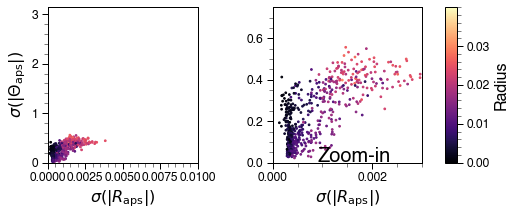

In [12]:

fig = plt.figure(figsize=(8,3))

ax1 = fig.add_axes([0.16,0.23,0.26,0.72]) # main axis
ax2 = fig.add_axes([0.55,0.23,0.26,0.72]) # main axis


ax3 = fig.add_axes([0.85,0.23,0.02,0.72]) # colorbar

clrs = cm.magma


cpalette = np.linspace(0.,0.04,100)
ax1.scatter(sigma_x,sigma_y,color=cm.magma( (x_position-np.min(cpalette))/(np.max(cpalette)),1.),s=3.)
ax1.axis([0.,0.01,0,3.141])

#ax1.fill_between([0.0,0.4],[1.5,1.5],[2.5,2.5],alpha=0.2,edgecolor='None')

ax2.scatter(sigma_x,sigma_y,color=cm.magma( (x_position-np.min(cpalette))/(np.max(cpalette)),1.),s=3.)
ax2.set_xticks([0.,0.002])
ax2.text(0.0009,0.004,'Zoom-in',size=20)


ax2.axis([0.,0.003,0,.75])



ax1.set_xlabel('$\\sigma(|R_{\\rm aps}|)$',size=16)
ax2.set_xlabel('$\\sigma(|R_{\\rm aps}|)$',size=16)


ax1.set_ylabel('$\\sigma(|\\Theta_{\\rm aps}|)$',size=16)
norm = mpl.colors.Normalize(vmin=np.min(cpalette), vmax=np.max(cpalette))
cb1 = mpl.colorbar.ColorbarBase(ax3, cmap=clrs,norm=norm)
cb1.set_label('Radius',size=16)
cb1.set_ticks([0.0,0.01,0.02,0.03])

plt.savefig('../figures/sigma_cuts.png')


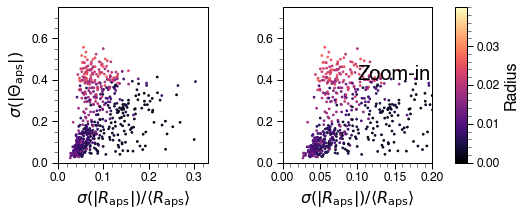

In [13]:
fig = plt.figure(figsize=(8,3))

ax1 = fig.add_axes([0.16,0.23,0.26,0.72]) # main axis
ax2 = fig.add_axes([0.55,0.23,0.26,0.72]) # main axis


ax3 = fig.add_axes([0.85,0.23,0.02,0.72]) # colorbar


clrs = cm.magma


cpalette = np.linspace(0.,0.04,100)
ax1.scatter(sigma_x/x_position,sigma_y,color=cm.magma( (x_position-np.min(cpalette))/(np.max(cpalette)),1.),s=3.)
ax1.axis([0.,0.33,0,.75])

#ax1.fill_between([0.0,0.4],[1.5,1.5],[2.5,2.5],alpha=0.2,edgecolor='None')

ax2.scatter(sigma_x/x_position,sigma_y,color=cm.magma( (x_position-np.min(cpalette))/(np.max(cpalette)),1.),s=3.)
ax2.axis([0.,0.2,0,0.75])
ax2.text(0.1,0.4,'Zoom-in',size=20)



ax1.set_xlabel('$\\sigma(|R_{\\rm aps}|)/\\langle R_{\\rm aps}\\rangle$',size=16)
ax2.set_xlabel('$\\sigma(|R_{\\rm aps}|)/\\langle R_{\\rm aps}\\rangle$',size=16)
ax1.set_ylabel('$\\sigma(|\\Theta_{\\rm aps}|)$',size=16)


norm = mpl.colors.Normalize(vmin=np.min(cpalette), vmax=np.max(cpalette))
cb1 = mpl.colorbar.ColorbarBase(ax3, cmap=clrs,norm=norm)
cb1.set_label('Radius',size=16)
cb1.set_ticks([0.0,0.01,0.02,0.03])

#plt.savefig('figures/norm_sigma_cuts.png')



Clearly, $\sigma_\Theta$ is the most powerful discriminator.

#### --- 3 ---
Now, we want to use $\langle \theta_{\rm bar}\rangle_N$ and $\sigma_{X_{\rm aps}}$ to define the bar. That is, find the particles who linger near the bar and do not disperse too far along the bar axis.

### Convert me to Relative sigma!

Also will need to do the same for the actual trapping code. Maybe a flag.

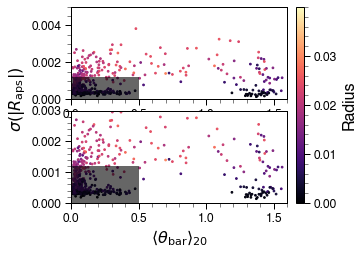

In [14]:

theta_cut = 0.5
sigma_cut = 0.0012


fig = plt.figure(figsize=(6,4))
ax1 = fig.add_axes([0.25,0.58,0.5,0.32]) # main axis
ax2 = fig.add_axes([0.25,0.22,0.5,0.32]) # main axis
ax3 = fig.add_axes([0.77,0.22,0.02,0.68]) # colorbar

clrs = cm.magma

cpalette = np.linspace(0.,0.04,100)
ax1.scatter(theta_20,sigma_x,color=cm.magma( (x_position-np.min(cpalette))/(np.max(cpalette)),1.),s=3.)
ax1.axis([0.0,1.6,0.0,0.005])
ax1.fill_between([0.0,theta_cut],[0.0,0.0],[sigma_cut,sigma_cut],color='black',edgecolor='None',alpha=0.6)

ax2.scatter(theta_20,sigma_x,color=cm.magma( (x_position-np.min(cpalette))/(np.max(cpalette)),1.),s=3.)
ax2.axis([0.0,1.6,0.0,0.003])
ax2.fill_between([0.0,theta_cut],[0.0,0.0],[sigma_cut,sigma_cut],color='black',edgecolor='None',alpha=0.6)

ax2.set_xlabel('$\\langle \\theta_{\\rm bar} \\rangle_{20}$',size=16)
ax1.set_ylabel('$\\sigma(|R_{\\rm aps}|)$',size=16,y=-0.)
norm = mpl.colors.Normalize(vmin=np.min(cpalette), vmax=np.max(cpalette))
cb1 = mpl.colorbar.ColorbarBase(ax3, cmap=clrs,norm=norm)
cb1.set_label('Radius',size=16); cb1.set_ticks([0.0,0.01,0.02,0.03])

#plt.savefig('figures/theta_sigma.png')




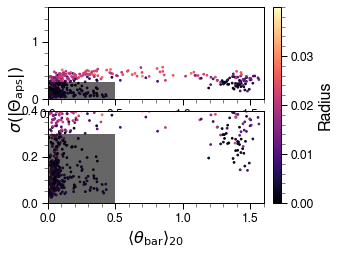

In [15]:

theta_cut = 0.5
sigma_cut = 0.3


fig = plt.figure(figsize=(6,4))
ax1 = fig.add_axes([0.25,0.58,0.5,0.32]) # main axis
ax2 = fig.add_axes([0.25,0.22,0.5,0.32]) # main axis
ax3 = fig.add_axes([0.77,0.22,0.02,0.68]) # colorbar

clrs = cm.magma

cpalette = np.linspace(0.,0.04,100)
ax1.scatter(theta_20,sigma_y,color=cm.magma( (x_position-np.min(cpalette))/(np.max(cpalette)),1.),s=3.)
ax1.axis([0.0,1.6,0.0,1.6])
ax1.fill_between([0.0,theta_cut],[0.0,0.0],[sigma_cut,sigma_cut],color='black',edgecolor='None',alpha=0.6)

ax2.scatter(theta_20,sigma_y,color=cm.magma( (x_position-np.min(cpalette))/(np.max(cpalette)),1.),s=3.)
ax2.axis([0.0,1.6,0.0,0.4])
ax2.fill_between([0.0,theta_cut],[0.0,0.0],[sigma_cut,sigma_cut],color='black',edgecolor='None',alpha=0.6)

ax2.set_xlabel('$\\langle \\theta_{\\rm bar} \\rangle_{20}$',size=16)
ax1.set_ylabel('$\\sigma(|\\Theta_{\\rm aps}|)$',size=16,y=-0.)
norm = mpl.colors.Normalize(vmin=np.min(cpalette), vmax=np.max(cpalette))
cb1 = mpl.colorbar.ColorbarBase(ax3, cmap=clrs,norm=norm)
cb1.set_label('Radius',size=16); cb1.set_ticks([0.0,0.01,0.02,0.03])

#plt.savefig('figures/theta_sigma.png')





This brings us close to what we were hoping for.

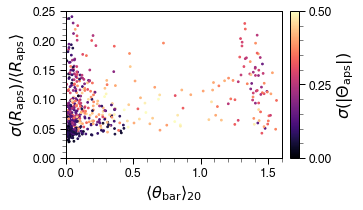

In [16]:

theta_cut = 0.5
sigma_cut = 0.1


fig = plt.figure(figsize=(6,3))
ax1 = fig.add_axes([0.25,0.22,0.5,0.68]) # main axis
#ax2 = fig.add_axes([0.25,0.22,0.5,0.32]) # main axis
ax3 = fig.add_axes([0.77,0.22,0.02,0.68]) # colorbar

clrs = cm.magma

cpalette = np.linspace(0.,0.5,100)
ax1.scatter(theta_20,sigma_x/x_position,color=cm.magma( (sigma_y-np.min(cpalette))/(np.max(cpalette)),1.),s=3.)
ax1.axis([0.0,1.6,0.0,0.25])
#ax1.fill_between([0.0,theta_cut],[0.0,0.0],[sigma_cut,sigma_cut],color='black',edgecolor='None',alpha=0.6)

#ax2.scatter(theta_20,sigma_x/x_position,color=cm.magma( (x_position-np.min(cpalette))/(np.max(cpalette)),1.),s=3.)
#ax2.axis([0.0,1.6,0.0,.3])
#ax2.fill_between([0.0,theta_cut],[0.0,0.0],[sigma_cut,sigma_cut],color='black',edgecolor='None',alpha=0.6)

ax1.set_xlabel('$\\langle \\theta_{\\rm bar} \\rangle_{20}$',size=16)
ax1.set_ylabel('$\\sigma(R_{\\rm aps})/\\langle R_{\\rm aps}\\rangle$',size=16)
norm = mpl.colors.Normalize(vmin=np.min(cpalette), vmax=np.max(cpalette))
cb1 = mpl.colorbar.ColorbarBase(ax3, cmap=clrs,norm=norm)
cb1.set_label('$\\sigma(|\\Theta_{\\rm aps}|)$',size=16); cb1.set_ticks([0.0,0.25,0.5,0.75,1.0])

plt.savefig('../figures/theta_sigma_sigma1.png')





This takes us further from what we were hoping for.

### Trapping Criteria, without normalization

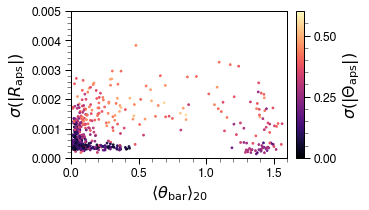

In [17]:

fig = plt.figure(figsize=(6,3))
ax1 = fig.add_axes([0.25,0.22,0.5,0.68]) # main axis
ax3 = fig.add_axes([0.77,0.22,0.02,0.68]) # colorbar

clrs = cm.magma

cpalette = np.linspace(0.,0.6,100)
ax1.scatter(theta_20,sigma_x,color=cm.magma( (sigma_y-np.min(cpalette))/(np.max(cpalette)),1.),s=3.)
ax1.axis([0.0,1.6,0.0,0.005])



ax1.set_xlabel('$\\langle \\theta_{\\rm bar} \\rangle_{20}$',size=16)
ax1.set_ylabel('$\\sigma(|R_{\\rm aps}|)$',size=16)
norm = mpl.colors.Normalize(vmin=np.min(cpalette), vmax=np.max(cpalette))
cb1 = mpl.colorbar.ColorbarBase(ax3, cmap=clrs,norm=norm)
cb1.set_label('$\\sigma(|\\Theta_{\\rm aps}|)$',size=16); cb1.set_ticks([0.0,0.25,0.5,0.75,1.0])

plt.savefig('../figures/theta_sigma_sigma_nonorm.png')






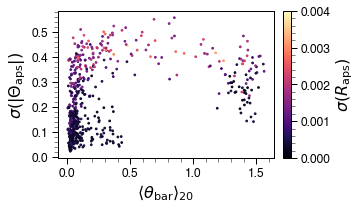

In [18]:

fig = plt.figure(figsize=(6,3))
ax1 = fig.add_axes([0.25,0.22,0.5,0.68]) # main axis
ax3 = fig.add_axes([0.77,0.22,0.02,0.68]) # colorbar

clrs = cm.magma

cpalette = np.linspace(0.,0.004,100)
ax1.scatter(theta_20,sigma_y,color=cm.magma( (sigma_x-np.min(cpalette))/(np.max(cpalette)),1.),s=3.)
#ax1.axis([0.0,1.6,0.0,0.005])



ax1.set_xlabel('$\\langle \\theta_{\\rm bar} \\rangle_{20}$',size=16)
ax1.set_ylabel('$\\sigma(|\\Theta_{\\rm aps}|)$',size=16)
norm = mpl.colors.Normalize(vmin=np.min(cpalette), vmax=np.max(cpalette))
cb1 = mpl.colorbar.ColorbarBase(ax3, cmap=clrs,norm=norm)
cb1.set_label('$\\sigma(R_{\\rm aps})$',size=16)
cb1.set_ticks([0.0,0.001,0.002,0.003,0.004])
#cb1.set_ticks([0.0,0.25,0.5,0.75,1.0])

plt.savefig('../figures/theta_sigma_sigma_nonorm.png')







With the combination of $\sigma_\Theta$ and $\sigma_R$, we can see that there is a path to discerning the bar feature.

### Check Trapping

Vizualize the model, with the trapped particles overlaid.

## Part 2: Time-resolved trapping

With family membership criteria defined above, track the membership in different families through the entire simulation.

In [19]:
# first, define the family boundaries, using the following metrics:

# [theta_20, r_freq, sigma_x, sigma_y, mean_x]

criteria = {}

# criteria will be based on the four-fold limits?
criteria[0] = [(0.,0.5),(33.,250.0),(0.0,0.0008),(0.0,0.005),(0.,1.)] # x1 orbits
criteria[1] = [(0.8,1.8),(100.,10000.0),(0.0,0.008),(0.0,0.001),(0.,1.)] # x2 orbits
criteria[2] = [(0.5,0.8),(33.,10000.0),(0.0,0.0008),(0.0,0.002),(0.,1.)] # wider x1 orbits
criteria[3] = [(0.,0.5),(33.,1000.0),(0.0008,0.002),(0.0,0.002),(0.,1.)] # less coherent x1
criteria[4] = [(0.0,1.7),(999.,10000.0),(0.0,1.0),(0.0,1.0),(0.,1.)] # nyquist excluded
criteria[5] = [(1.0,1.7),(2.,100.0),(0.0,0.01),(0.0,0.01),(0.02,0.05)] # trying to find those fixed orbits

criteria[0] = [(0.,0.5),(33.,251.0),(0.0,0.0008),(0.0,0.005),(0.,1.)] # x1 orbits
criteria[1] = [(0.8,1.8),(100.,251.0),(0.0,0.008),(0.0,0.001),(0.,1.)] # x2 orbits
criteria[2] = [(0.5,0.8),(33.,251.0),(0.0,0.0008),(0.0,0.002),(0.,1.)] # wider x1 orbits
criteria[3] = [(0.,0.5),(33.,251.0),(0.0008,0.002),(0.0,0.002),(0.,1.)] # less coherent x1
criteria[4] = [(0.0,1.7),(251.,10000.0),(0.0,1.0),(0.0,1.0),(0.,1.)] # nyquist excluded
criteria[5] = [(1.0,1.7),(2.,251.0),(0.0,0.01),(0.0,0.01),(0.02,0.05)] # trying to find those fixed orbits
criteria[6] = [(0.,0.5),(1.,251.0),(0.0,0.002),(0.0,0.002),(0.,1.)] # x1 orbits
criteria[7] = [(0.5,0.8),(1.,251.0),(0.0,0.002),(0.0,0.002),(0.,1.)] # wider x1 orbits
criteria[8] = [(0.,0.5),(1.,251.0),(0.0008,0.002),(0.0,0.002),(0.,1.)] # less coherent x1



# polar trapping criteria
criteria = {}
criteria[0] = [(0.0,np.pi/6.),(33.,251.0),(0.0,0.001),(0.0,np.pi/16.),(0.,0.025)] # x1 orbits
criteria[1] = [(3*np.pi/8.,np.pi/2.),(33.,251.0),(0.0,0.001),(0.0,np.pi/8.),(0.,1.)] # x2 orbits
criteria[2] = [(0.0,np.pi/6.),(33.,251.0),(0.0,0.0010),(np.pi/16.,np.pi/8.),(0.,1.)] # generic bar supporting
criteria[3] = [(0.0,np.pi/2.),(251.,10000.0),(0.0,1.0),(0.0,2.0),(0.,1.)] # nyquist excluded
criteria[4] = [(0.0,np.pi/6.),(33.,251.0),(0.001,0.0015),(np.pi/16.,np.pi/8.),(0.,1.)] # loose generic bar supporting
criteria[5] = [(0.0,np.pi/2.),(10.,251.0),(0.00,0.005),(0,np.pi/16.),(0.02,1.)] # lagrange
criteria[6] = [(0.0,np.pi/16.),(10.,251.0),(0.00,0.001),(np.pi/16.,np.pi/6.),(0.00,0.015)] # 
#criteria[7] = [(0.0,np.pi/6.),(33.,50.0),(0.0,0.001),(0.0,np.pi/16.),(0.,0.025)] # x1 orbits: low freq
#criteria[8] = [(0.0,np.pi/6.),(50.,251.0),(0.0,0.001),(0.0,np.pi/16.),(0.,0.025)] # x1 orbits: high freq











# execute the trapping, which attempts to use multiprocessing
trapping_array = trapping.do_kmeans_multi(TrappingInstance,BarInstance,\
                   sbuffer=20,\
                   t_thresh=1.5,\
                   criteria=criteria,\
                   verbose=2,polar=True,maxima=True)#,rank=True,perc=90.)



Beginning kmeans, using 4 processors.
Total trapping calculation took 61.41 seconds, or 61.29 milliseconds per orbit.


### Plot the trapping families over time

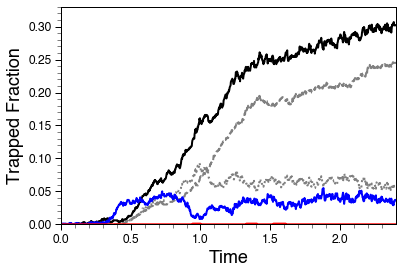

In [20]:

plt.figure(figsize=(6,4))


plt.plot(BarInstance.time,np.sum(trapping_array[0],axis=0)/float(TrappingInstance['norb']),color='gray',linestyle='dashed')
plt.plot(BarInstance.time,np.sum(trapping_array[2],axis=0)/float(TrappingInstance['norb']),color='gray',linestyle='dotted')

plt.plot(BarInstance.time,(np.sum(trapping_array[0],axis=0)+np.sum(trapping_array[2],axis=0))/float(TrappingInstance['norb']),color='black')

plt.plot(BarInstance.time,np.sum(trapping_array[1],axis=0)/float(TrappingInstance['norb']),color='blue')
plt.plot(BarInstance.time,np.sum(trapping_array[5],axis=0)/float(TrappingInstance['norb']),color='red')




    
plt.xlabel('Time',size=18)
plt.ylabel('Trapped Fraction',size=18)
_ = plt.axis([0.0,2.4,0.,0.33])



plt.savefig('../figures/trapped_fraction.png')



# Part 3: Trapping Routines at Scale

In order to produce the necessary files above, this part walks through how to analyze the raw OUT files from EXP.

For members of the UMass group, this may be run in an interactive job on eagle, i.e.

1. srun -n1 --pty --x11=first $SHELL
2. python
3. [various imports to run the steps below]

In [ ]:
# define key parameters
dir_name = 'Disk001'
run_name = 'run001'
trapping_comp = 'star'
outfilemax = 2450 # largest output number

basedir = '/scratch/mpetersen/'
indir = basedir+dir_name+'/'
bar_file = indir+run_name+'_barpos.dat'
aps_file = indir+aps_name
simfile_name = indir+'simfiles.dat'



In [ ]:
# generate a list of all files to use in analysis
# backup way, as the current method in psp_io is broken
f = open(simfile_name,'w')

for indx in range(0,outfilemax):
    print(indir+'OUT.'+run_name+'.{0:05d}'.format(indx),file=f)
    
f.close()


In [ ]:
# use the coefficient files to generate a bar file
EOF2Dict = eof.read_binary_eof_coefficients_dict(indir+'outcoef.star.'+run_name)

DC = eof.reorganize_eof_dict(EOF2Dict)
DCp = eof.calculate_eof_phase(EOF2Dict)

morder=2
norder=0
eof.print_eof_barfile(DCp,indir,run_name,morder=morder,norder=norder)

# update the bar file name
bar_file = indir+run_name+'_m{}n{}_barpos.dat'.format(morder,norder)

# and read in the bar file
BarInstance = pattern.BarDetermine()
BarInstance.read_bar(bar_file)



In [ ]:
# generate the aps file, as used in part 1

A = trapping.ApsFinding()
TrappingInstance = A.determine_r_aps(simfile_name,trapping_comp,nout=100000,out_directory=indir,return_aps=True)
print(TrappingInstance['desc'])


# a file stamped with the current time will be generated


In [ ]:

# polar trapping criteria, from PWK20a
criteria = {}
criteria[0] = [(0.0,np.pi/6.),(33.,251.0),(0.0,0.001),(0.0,np.pi/16.),(0.,0.025)] # x1 orbits
criteria[1] = [(3*np.pi/8.,np.pi/2.),(33.,251.0),(0.0,0.001),(0.0,np.pi/8.),(0.,1.)] # x2 orbits
criteria[2] = [(0.0,np.pi/6.),(33.,251.0),(0.0,0.0010),(np.pi/16.,np.pi/8.),(0.,1.)] # generic bar supporting
criteria[3] = [(0.0,np.pi/2.),(251.,10000.0),(0.0,1.0),(0.0,2.0),(0.,1.)] # nyquist excluded
criteria[4] = [(0.0,np.pi/6.),(33.,251.0),(0.001,0.0015),(np.pi/16.,np.pi/8.),(0.,1.)] # loose generic bar supporting


# execute the trapping, which attempts to use multiprocessing
trapping_array = trapping.do_kmeans_multi(TrappingInstance,BarInstance,\
                   sbuffer=20,\
                   t_thresh=1.5,\
                   criteria=criteria,\
                   verbose=2,polar=True)



for critnum in criteria.keys():
    trapping.write_trapping_file(trapping_array[critnum],BarInstance.time,indir+'trapping_criteria2_080618_{}.dat'.format(critnum),tdtype='i1')





In [ ]:
# read in and plot

trapping_array = {}
for critnum in criteria.keys():
    bar_times,trapping_array[critnum] = trapping.read_trapping_file(indir+'trapping_criteria_080618_{}.dat'.format(critnum),tdtype='i1')


plt.plot(BarInstance.time,np.sum(new_trap[0],axis=0)/float(new_trap[0].shape[0]))

plt.plot(BarInstance.time,(np.sum(new_trap[0],axis=0)+np.sum(new_trap[3],axis=0))/float(new_trap[0].shape[0]))




# Appendix 1

Demonstrating the aps positions for a single orbit (verification of the method)

In [ ]:

def evaluate_clusters_polar(K,maxima=False,rank=False,perc=0.):
    '''
    evaluate_clusters_polar
        calculate statistics for clusters in polar coordinates
        
    inputs
    -------------
    K
    maxima
    rank
    perc
    
    
    returns
    -------------
    theta_n
    clustermean
    clusterstd_r
    clusterstd_t
    
    
    
    '''
    k = K.K

    if (rank) & (perc==0.):
        print('evaluate_clusters_polar: Perc must be >0.')
        return np.nan,np.nan,np.nan,np.nan
    
    
    # compute radii and theta values from clusters
    rad_clusters = np.array([np.sum(np.array(K.clusters[i])*np.array(K.clusters[i]),axis=1)**0.5 for i in range(0,k)])


    
    #the_clusters = np.array([np.arctan(np.abs(np.array(K.clusters[i])[:,1])/np.abs(np.array(K.clusters[i])[:,0])) for i in range(0,k)])
    
    # try not just first quadrant clustering
    the_clusters = np.array([np.arctan((np.array(K.clusters[i])[:,1])/(np.array(K.clusters[i])[:,0])) for i in range(0,k)])


    
    if maxima:
        # use maxima
        
        clustermean = np.max([np.mean(rad_clusters[i]) for i in range(0,k)])

        theta_n = np.max([abs(np.arctan(K.mu[i][1]/K.mu[i][0])) for i in range(0,k)])
        theta_n = np.max([(np.arctan(K.mu[i][1]/K.mu[i][0])) for i in range(0,k)])


    
        if rank:
            # use rank ordered
        
            organized_rad = np.array([rad_clusters[i][rad_clusters[i].argsort()] for i in range(0,k)])
            organized_the = np.array([the_clusters[i][the_clusters[i].argsort()] for i in range(0,k)])

            clusterstd_r = np.max(np.percentile(organized_rad,perc))
            clusterstd_t = np.max(np.percentile(organized_the,perc))

        else:
            clusterstd_r = np.max([np.std(rad_clusters[i]) for i in range(0,k)])
            clusterstd_t = np.max([np.std(the_clusters[i]) for i in range(0,k)])
            clusterstd_t = np.max([np.abs(np.max(the_clusters[i])-np.min(the_clusters[i])) for i in range(0,k)])


            
    else:
        
        # not maxima
        
        if rank:
            # use rank ordered
        
            organized_rad = np.array([rad_clusters[i][rad_clusters[i].argsort()] for i in range(0,k)])
            organized_the = np.array([the_clusters[i][the_clusters[i].argsort()] for i in range(0,k)])

            clusterstd_r = np.mean(np.percentile(organized_rad,perc))
            clusterstd_t = np.mean(np.percentile(organized_the,perc))

        else:
            clusterstd_r = np.mean([np.std(rad_clusters[i]) for i in range(0,k)])
            clusterstd_t = np.mean([np.std(the_clusters[i]) for i in range(0,k)])
            
        clustermean = np.mean([np.mean(rad_clusters[i]) for i in range(0,k)])
        theta_n = np.mean([abs(np.arctan(K.mu[i][1]/K.mu[i][0])) for i in range(0,k)])
        theta_n = np.mean([(np.arctan(K.mu[i][1]/K.mu[i][0])) for i in range(0,k)])

    return theta_n,clustermean,clusterstd_r,clusterstd_t


def process_kmeans_polar(ApsArray,indx=-1,k=2,maxima=False,rank=False,perc=0.):
    '''
    #
    # robust kmeans implementation
    #
    #    -can be edited for speed
    #    -confined to two dimensions
    #    -computes trapping metrics in polar coordinates

    inputs
    ----------
    ApsArray         : the array of aps for an individual orbit
    indx             : a designation of the orbit, for use with multiprocessing
    k                : the number of clusters
    maxima           : calculate average (if False) or maximum (if True) quantities
    mad              : toggle median absolute deviation calculation


    returns
    ----------
    theta_n          : (see explanation at beginning for definitions)
    clustermean      :
    clusterstd_r     :
    clusterstd_theta :
    kmeans_plus_flag :




    '''
    kmeans_plus_flag = 0
    reject_cluster_flag = 0
    min_cluster_size = 1


    K = kmeans.KMeans(k,X=ApsArray)
    K.find_centers()
        

        
    # find the standard deviation of clusters
    try:
        clustersize = np.array([np.array(K.clusters[c]).size/2. for c in range(0,k)])    
    
        # eliminate
        while np.min(clustersize) <= min_cluster_size:
            w = np.where(clustersize > min_cluster_size)[0]
            new_aps = np.array([np.concatenate([np.array(K.clusters[x])[:,0] for x in w]),\
                        np.concatenate([np.array(K.clusters[x])[:,1] for x in w])]).T
    
            K = kmeans.KMeans(k,X=new_aps)
            K.find_centers()
            clustersize = np.array([np.array(K.clusters[c]).size/2. for c in range(0,k)])
            
        theta_n,clustermean,clusterstd_r,clusterstd_t = \
        evaluate_clusters_polar(K,maxima=maxima,rank=rank,perc=perc)


    # failure on basic kmeans
    except:
        K = kmeans.KPlusPlus(k,X=ApsArray)
        K.init_centers()
        K.find_centers(method='++')
        kmeans_plus_flag = 1
        

        
        try:
            clustersize = np.array([np.array(K.clusters[c]).size/2. for c in range(0,k)])
            

            while np.min(clustersize) <= min_cluster_size:
                w = np.where(clustersize > min_cluster_size)[0]
                new_aps = np.array([np.concatenate([np.array(K.clusters[x])[:,0] for x in w]),\
                        np.concatenate([np.array(K.clusters[x])[:,1] for x in w])]).T
    
                K = kmeans.KPlusPlus(k,X=new_aps)
                K.init_centers()
                K.find_centers(method='++')
                clustersize = np.array([np.array(K.clusters[c]).size/2. for c in range(0,k)])



            theta_n,clustermean,clusterstd_r,clusterstd_t = \
                evaluate_clusters_polar(K,maxima=maxima,rank=rank,perc=perc)



        # failure mode for advanced kmeans
        except:
            
            #
            # would like a more intelligent way to diagnose
            #if indx >= 0:
            #    print 'Orbit %i even failed in Kmeans++!!' %indx
            clusterstd_r = np.nan
            clusterstd_t = np.nan
            clustermean = np.nan
            theta_n = np.nan
            kmeans_plus_flag = 2

    #try:
    #    print([(np.arctan(K.mu[i][1]/K.mu[i][0])) for i in range(0,k)])
    #except:
    #    pass
    
    return theta_n,clustermean,clusterstd_r,clusterstd_t,kmeans_plus_flag




In [ ]:


def do_single_kmeans_step(TrappingInstanceDict,BarInstance,desired_time,\
                          sbuffer=20,\
                          t_thresh=1.5,\
                          maxima=False,\
                          mad=False,\
                          k=2,\
                          verbose=1,
                              polar=False,\
                              rank=False,perc=0.,fold=False): 
    '''
    do_single_kmeans_step: analyze a desired time in the trapping dictionary


    inputs
    ----------
    TrappingInstanceDict :
    BarInstance          :
    desired_time         :
    sbuffer              : number of closest aps (forward and backward looking) to include in clustering
    t_thresh             :
    maxima               :
    verbose              :
    polar
    rank
    perc

    returns
    ----------
    theta_20
    r_frequency
    x_position
    sigma_x
    sigma_y

    note--all are set to np.nan if unclassifiable for some reason
                          
    '''
    norb = TrappingInstanceDict['norb']

    theta_20 = np.zeros(norb)
    r_frequency = np.zeros(norb)
    x_position = np.zeros(norb)
    sigma_x = np.zeros(norb)
    sigma_y = np.zeros(norb)

    # keep track of base statistics
    skipped_for_aps = 0
    skipped_for_res = 0
    sent_to_kmeans_plus = 0
    failed_kmeans_plus = 0

    t1 = time.time()

    
    for indx in range(0,norb):
        if ((indx % (norb/100)) == 0) & (verbose > 0):  utils.print_progress(indx,norb,'trapping.do_single_kmeans_step')
        #

        # block loop completely if too few aps
        if len(TrappingInstanceDict[indx][:,0]) < sbuffer:
            skipped_for_aps += 1

            theta_20[indx] = np.nan
            r_frequency[indx] = np.nan
            x_position[indx] = np.nan
            sigma_x[indx] = np.nan
            sigma_y[indx] = np.nan
            
            continue


        # find the closest aps
        relative_aps_time = abs(TrappingInstanceDict[indx][:,0] - desired_time)
        closest_aps = (relative_aps_time).argsort()[0:sbuffer]

        # block loop if furthest aps is above some time threshold
        if relative_aps_time[closest_aps[-1]] > t_thresh:
            skipped_for_res += 1

            theta_20[indx] = np.nan
            r_frequency[indx] = np.nan
            x_position[indx] = np.nan
            sigma_x[indx] = np.nan
            sigma_y[indx] = np.nan
            
            continue


        # transform to bar frame
        X = trapping.transform_aps(TrappingInstanceDict[indx],BarInstance)

        # perform an X folding if desired
        if fold: X = np.array([np.abs(X[:,0]),X[:,1]]).T



        # do k-means

        if polar:
            theta_n,clustermean,clusterstd_x,clusterstd_y,kmeans_plus_flag = process_kmeans_polar(X[closest_aps],k=k,maxima=maxima,rank=rank,perc=perc)

        else:
            theta_n,clustermean,clusterstd_x,clusterstd_y,kmeans_plus_flag = process_kmeans(X[closest_aps],k=k,maxima=maxima,mad=mad)


        if kmeans_plus_flag == 1: sent_to_kmeans_plus += 1

        if kmeans_plus_flag == 2: failed_kmeans_plus += 1

        # set the values for each orbit
        theta_20[indx] = theta_n

        r_frequency[indx] =  1./(TrappingInstanceDict[indx][closest_aps[0],0] -\
                                 TrappingInstanceDict[indx][closest_aps[0]-1,0])

        x_position[indx] = clustermean
        sigma_x[indx] = clusterstd_x
        sigma_y[indx] = clusterstd_y


    if (verbose > 1):
        t2 = time.time()
        print('K-means took {0:3.2f} seconds ({1:3.2f} ms per orbit)'.format(t2, t2/norb*1000))

    print('skipped_for_aps',skipped_for_aps)
    print('skipped_for_res',skipped_for_res)
    print('sent_to_kmeans_plus',sent_to_kmeans_plus)
    print('failed_kmeans_plus',failed_kmeans_plus)


    return theta_20,r_frequency,x_position,sigma_x,sigma_y




In [ ]:
# convert trapping Instance to have positive values in X only

for orb in range(0,1000):
    TrappingInstance[orb] = np.array([TrappingInstance[orb][:,0],\
                                      np.abs(TrappingInstance[orb][:,1]),\
                                      TrappingInstance[orb][:,2],\
                                      TrappingInstance[orb][:,3]]).T



In [ ]:
theta_20b,r_frequencyb,x_positionb,sigma_xb,sigma_yb = \
do_single_kmeans_step(TrappingInstance,BarInstance,desired_time,\
                          sbuffer=20,\
                          t_thresh=1.5,\
                          maxima=False,\
                          verbose=1,\
                              mad=False,\
                              k=2,\
                               polar=True,fold=True)#,rank=True,perc=90.)

In [ ]:

fig = plt.figure(figsize=(6,3))
ax1 = fig.add_axes([0.25,0.22,0.5,0.68]) # main axis
ax3 = fig.add_axes([0.77,0.22,0.02,0.68]) # colorbar

clrs = cm.magma

cpalette = np.linspace(0.,0.004,100)
ax1.scatter(np.abs(theta_20),sigma_y,color=cm.magma( (sigma_x-np.min(cpalette))/(np.max(cpalette)),1.),s=3.)
#ax1.axis([0.0,1.6,0.0,0.005])



ax1.set_xlabel('$\\langle \\theta_{\\rm bar} \\rangle_{20}$',size=16)
ax1.set_ylabel('$\\sigma(|\\Theta_{\\rm aps}|)$',size=16)
norm = mpl.colors.Normalize(vmin=np.min(cpalette), vmax=np.max(cpalette))
cb1 = mpl.colorbar.ColorbarBase(ax3, cmap=clrs,norm=norm)
cb1.set_label('$\\sigma(R_{\\rm aps})$',size=16)
cb1.set_ticks([0.0,0.001,0.002,0.003,0.004])
#cb1.set_ticks([0.0,0.25,0.5,0.75,1.0])

#plt.savefig('figures/theta_sigma_sigma_nonorm.png')








In [ ]:
theta_20,r_frequency,x_position,sigma_x,sigma_y = \
do_single_kmeans_step(TrappingInstance,BarInstance,desired_time,\
                          sbuffer=20,\
                          t_thresh=1.5,\
                          maxima=False,\
                          verbose=1,\
                              mad=False,\
                              k=1,\
                               polar=True,fold=True)#,rank=True,perc=90.)

In [ ]:

fig = plt.figure(figsize=(6,3))
ax1 = fig.add_axes([0.25,0.22,0.5,0.68]) # main axis
ax3 = fig.add_axes([0.77,0.22,0.02,0.68]) # colorbar

clrs = cm.magma

cpalette = np.linspace(0.,0.004,100)
ax1.scatter(np.abs(theta_20),sigma_y,color=cm.magma( (sigma_x-np.min(cpalette))/(np.max(cpalette)),1.),s=3.)
#ax1.axis([0.0,1.6,0.0,0.005])



ax1.set_xlabel('$\\langle \\theta_{\\rm bar} \\rangle_{20}$',size=16)
ax1.set_ylabel('$\\sigma(|\\Theta_{\\rm aps}|)$',size=16)
norm = mpl.colors.Normalize(vmin=np.min(cpalette), vmax=np.max(cpalette))
cb1 = mpl.colorbar.ColorbarBase(ax3, cmap=clrs,norm=norm)
cb1.set_label('$\\sigma(R_{\\rm aps})$',size=16)
cb1.set_ticks([0.0,0.001,0.002,0.003,0.004])
#cb1.set_ticks([0.0,0.25,0.5,0.75,1.0])

#plt.savefig('figures/theta_sigma_sigma_nonorm.png')









In [ ]:



fig = plt.figure(figsize=(6,3))
ax1 = fig.add_axes([0.25,0.22,0.5,0.68]) # main axis
ax3 = fig.add_axes([0.77,0.22,0.02,0.68]) # colorbar

clrs = cm.magma

cpalette = np.linspace(0.,0.03,100)
ax1.scatter(np.abs(theta_20) - np.abs(theta_20b),sigma_y - sigma_yb,color=cm.magma( ((x_position)-np.min(cpalette))/(np.max(cpalette)),1.),s=3.)
#ax1.axis([0.0,1.6,0.0,0.005])



ax1.set_xlabel('$\\Delta\\langle \\theta_{\\rm bar} \\rangle_{20}$',size=16)
ax1.set_ylabel('$\\Delta\\sigma(|\\Theta_{\\rm aps}|)$',size=16)
norm = mpl.colors.Normalize(vmin=np.min(cpalette), vmax=np.max(cpalette))
cb1 = mpl.colorbar.ColorbarBase(ax3, cmap=clrs,norm=norm)
cb1.set_label('$\\langle R_{\\rm aps}\\rangle$',size=16)
cb1.set_ticks([0.0,0.01,0.02,0.03,0.04])
#cb1.set_ticks([0.0,0.25,0.5,0.75,1.0])

plt.savefig('../figures/diff_values.png')










In [ ]:
w = np.where((np.abs(theta_20) - np.abs(theta_20b) < -.1) \
             & ( (sigma_y - sigma_yb)>0.5)\
             & ( (x_position)<0.02)\
            & ( (x_position)>0.008))[0]
print(w)

In [ ]:
# find an orbit with several aps to choose from

indx = 81

while (len(TrappingInstance[indx]) < 20) : indx += 1
    
print('selected orbit',indx)

# using the desired time, find 20 closest aps
desired_time = 2.0
sbuffer = 20

relative_aps_time = abs(TrappingInstance[indx][:,0] - desired_time)
closest_aps = (relative_aps_time).argsort()[0:sbuffer]

X = trapping.transform_aps(TrappingInstance[indx],BarInstance)

#print(X[closest_aps])
#X = np.array([np.abs(X[:,0]),X[:,1]]).T
#print(X[closest_aps])


k=2
#theta_n,clustermean,clusterstd_x,clusterstd_y,kmeans_plus_flag = trapping.process_kmeans(X[closest_aps],maxima=False)
#theta_n,clustermean,clusterstd_x,clusterstd_y,kmeans_plus_flag = trapping.process_kmeans_polar(X[closest_aps],maxima=False,rank=False,perc=0.)
theta_n,clustermean,clusterstd_x,clusterstd_y,kmeans_plus_flag = process_kmeans_polar(X[closest_aps],k=k,maxima=False,rank=False,perc=0.)

print('{0:>12s}{1:>12s}{2:>12s}{3:>12s}{4:>12s}'.format('theta_n','sigma_R/R','R','sigma_R','sigma_T'))
print('{0:12.3f}{1:12.3f}{2:12.3f}{3:12.4f}{4:12.3f}'.format(theta_n,clusterstd_x/clustermean,clustermean,clusterstd_x,clusterstd_y))



k=4
#theta_n,clustermean,clusterstd_x,clusterstd_y,kmeans_plus_flag = trapping.process_kmeans(X[closest_aps],maxima=False)
#theta_n,clustermean,clusterstd_x,clusterstd_y,kmeans_plus_flag = trapping.process_kmeans_polar(X[closest_aps],maxima=False,rank=False,perc=0.)
theta_n,clustermean,clusterstd_x,clusterstd_y,kmeans_plus_flag = process_kmeans_polar(X[closest_aps],k=k,maxima=False,rank=False,perc=0.)

print('{0:>12s}{1:>12s}{2:>12s}{3:>12s}{4:>12s}'.format('theta_n','sigma_R/R','R','sigma_R','sigma_T'))
print('{0:12.3f}{1:12.3f}{2:12.3f}{3:12.4f}{4:12.3f}'.format(theta_n,clusterstd_x/clustermean,clustermean,clusterstd_x,clusterstd_y))





In [ ]:


while (len(TrappingInstance[indx]) < 20) : indx += 1
    
print('selected orbit',indx)

# using the desired time, find 20 closest aps
desired_time = 2.0
sbuffer = 20

relative_aps_time = abs(TrappingInstance[indx][:,0] - desired_time)
closest_aps = (relative_aps_time).argsort()[0:sbuffer]

X = trapping.transform_aps(TrappingInstance[indx],BarInstance)

#print(X[closest_aps])
X = np.array([np.abs(X[:,0]),X[:,1]]).T
#print(X[closest_aps])





k=2
K = kmeans.KMeans(k,X=X[closest_aps])
K.find_centers()
#print(np.array(K.mu))
print('original cluster sizes:',[np.array(K.clusters[x]).size/2 for x in range(0,k)])


clustersize = np.array([np.array(K.clusters[c]).size/2. for c in range(0,k)])

min_cluster_size = 1
while np.min(clustersize) <= min_cluster_size:
    w = np.where(clustersize > min_cluster_size)[0]
    print(w)
    new_aps = np.array([np.concatenate([np.array(K.clusters[x])[:,0] for x in w]),\
                        np.concatenate([np.array(K.clusters[x])[:,1] for x in w])]).T
    
    K = kmeans.KMeans(k,X=new_aps)
    K.find_centers()
    print('revised cluster sizes',[np.array(K.clusters[x]).size/2 for x in range(0,k)])
    clustersize = np.array([np.array(K.clusters[c]).size/2. for c in range(0,k)])


    
print([(np.arctan(K.mu[i][1]/K.mu[i][0])) for i in range(0,k)])

    
rad_clusters = np.array([np.sum(np.array(K.clusters[i])*np.array(K.clusters[i]),axis=1)**0.5 for i in range(0,k)])


rad_clusters = np.array([np.sum(np.array(K.clusters[i])*np.array(K.clusters[i]),axis=1)**0.5 for i in range(0,k)])
the_clusters = np.array([np.arctan(np.abs(np.array(K.clusters[i])[:,1])/np.abs(np.array(K.clusters[i])[:,0])) for i in range(0,k)])

#print(rad_clusters.argsort()[0])

organized_rad = np.array([rad_clusters[i][rad_clusters[i].argsort()] for i in range(0,k)])

#print(rad2[1])

print('mean theta',[np.mean(the_clusters[i]) for i in range(0,k)])
print('std theta',[np.std(the_clusters[i]) for i in range(0,k)])

# with some sort of rank ordering for distance to check for outliers? 
# particularly in angle

print('mean r',[np.mean(rad_clusters[i]) for i in range(0,k)])
print('std r',[np.std(rad_clusters[i]) for i in range(0,k)])

In [ ]:
fig = plt.figure(figsize=(6,4))


    
ax1 = fig.add_axes([0.25,0.25,0.45,0.65]) # main axis
ax2 = fig.add_axes([0.78,0.25,0.02,0.65]) # colorbar
    
clrs = cm.magma

cpalette = np.linspace(np.min(TrappingInstance[indx][closest_aps,0]),np.max(TrappingInstance[indx][closest_aps,0]),100)

xmax = 0.045
theta_thresh = 8.

ax1.scatter(X[closest_aps,0],X[closest_aps,1],color=cm.magma( (TrappingInstance[indx][closest_aps,0]-np.min(cpalette))/(np.max(cpalette)-np.min(cpalette)),1.),s=18.,)

ax1.plot([-xmax*np.cos(np.pi/theta_thresh),xmax*np.cos(np.pi/theta_thresh)],[-xmax*np.sin(np.pi/theta_thresh),xmax*np.sin(np.pi/theta_thresh)],color='black',lw=1.,linestyle='dotted') #nyquist
ax1.plot([-xmax*np.cos(np.pi/theta_thresh),xmax*np.cos(np.pi/theta_thresh)],[xmax*np.sin(np.pi/theta_thresh),-xmax*np.sin(np.pi/theta_thresh)],color='black',lw=1.,linestyle='dotted') #nyquist
    
ax1.scatter(np.array(K.mu)[:,0],np.array(K.mu)[:,1],color='cyan',s=12.,marker='x',lw=1.,zorder=12)


    #ax1.scatter([-clustermean*np.cos(theta_n),clustermean*np.cos(theta_n)],[-clustermean*np.sin(theta_n),clustermean*np.sin(theta_n)],color='black',s=12.,marker='x',lw=1.)

    
ax1.axis([-xmax,xmax,-xmax,xmax])


ax1.set_xlabel('X$_{\\rm bar}$',size=20)
ax1.set_ylabel('Y$_{\\rm bar}$',size=20)
norm = mpl.colors.Normalize(vmin=np.min(cpalette), vmax=np.max(cpalette))
cb1 = mpl.colorbar.ColorbarBase(ax2, cmap=clrs,norm=norm)
cb1.set_label('Time',size=20)
    #cb1.set_ticks([0.0,0.01,0.02,0.03])




theta_n   sigma_R/R           R     sigma_R     sigma_T
       0.406       0.057       0.007       0.000       0.184

Now, plot the position of the apsides.

In [ ]:
fig = plt.figure(figsize=(6,4))



for indx in range(0,1000):
    # using the desired time, find 20 closest aps
    desired_time = 2.0
    sbuffer = 20
    
    if (len(TrappingInstance[indx]) < 20) : continue


    relative_aps_time = abs(TrappingInstance[indx][:,0] - desired_time)
    closest_aps = (relative_aps_time).argsort()[0:sbuffer]

    X = trapping.transform_aps(TrappingInstance[indx],BarInstance)
    X = np.array([np.abs(X[:,0]),(X[:,1])]).T

    #theta_n,clustermean,clusterstd_x,clusterstd_y,kmeans_plus_flag = trapping.process_kmeans(X[closest_aps],maxima=False)
    #theta_n,clustermean,clusterstd_x,clusterstd_y,kmeans_plus_flag = trapping.process_kmeans_polar(X[closest_aps],k=4,maxima=False,rank=False,perc=0.)
    theta_n,clustermean,clusterstd_x,clusterstd_y,kmeans_plus_flag = process_kmeans_polar(X[closest_aps],k=2,maxima=False,rank=False,perc=0.)


    k=2
    K = kmeans.KMeans(k,X=X[closest_aps])
    K.find_centers()
    
    if (np.array(K.clusters[0]).size < 5) | (np.array(K.clusters[1]).size < 5):
        if np.array(K.clusters[0]).size < np.array(K.clusters[1]).size:
            retry = np.array(K.clusters[1])
        else:
            retry = np.array(K.clusters[0])
        K = kmeans.KMeans(k,X=retry)
        K.find_centers()


    plt.clf()
    fig = plt.gcf()
    ax1 = fig.add_axes([0.25,0.25,0.45,0.65]) # main axis
    ax2 = fig.add_axes([0.78,0.25,0.02,0.65]) # colorbar
    
    clrs = cm.magma

    cpalette = np.linspace(np.min(TrappingInstance[indx][closest_aps,0]),np.max(TrappingInstance[indx][closest_aps,0]),100)

    xmax = 0.045
    theta_thresh = 8.
    print('theta_n','sigma_R/R','R','sigma_R','sigma_T')
    print(theta_n,clusterstd_x/clustermean,clustermean,clusterstd_x,clusterstd_y)

    ax1.scatter(X[closest_aps,0],X[closest_aps,1],color=cm.magma( (TrappingInstance[indx][closest_aps,0]-np.min(cpalette))/(np.max(cpalette)-np.min(cpalette)),1.),s=18.,)

    ax1.plot([-xmax*np.cos(np.pi/theta_thresh),xmax*np.cos(np.pi/theta_thresh)],[-xmax*np.sin(np.pi/theta_thresh),xmax*np.sin(np.pi/theta_thresh)],color='black',lw=1.,linestyle='dotted') #nyquist
    ax1.plot([-xmax*np.cos(np.pi/theta_thresh),xmax*np.cos(np.pi/theta_thresh)],[xmax*np.sin(np.pi/theta_thresh),-xmax*np.sin(np.pi/theta_thresh)],color='black',lw=1.,linestyle='dotted') #nyquist
    
    ax1.scatter(np.array(K.mu)[:,0],np.array(K.mu)[:,1],color='cyan',s=12.,marker='x',lw=1.,zorder=12)


    #ax1.scatter([-clustermean*np.cos(theta_n),clustermean*np.cos(theta_n)],[-clustermean*np.sin(theta_n),clustermean*np.sin(theta_n)],color='black',s=12.,marker='x',lw=1.)

    
    ax1.axis([-xmax,xmax,-xmax,xmax])


    ax1.set_xlabel('X$_{\\rm bar}$',size=20)
    ax1.set_ylabel('Y$_{\\rm bar}$',size=20)
    norm = mpl.colors.Normalize(vmin=np.min(cpalette), vmax=np.max(cpalette))
    cb1 = mpl.colorbar.ColorbarBase(ax2, cmap=clrs,norm=norm)
    cb1.set_label('Time',size=20)
    #cb1.set_ticks([0.0,0.01,0.02,0.03])


    plt.savefig('../figures/all_4kmeans{0:03d}.png'.format(indx))



## Make a gif

In [ ]:
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16



dt = 0.05


for desired_time in np.arange(0,2.5,dt):
    theta_20,r_frequency,x_position,sigma_x,sigma_y = \
    trapping.do_single_kmeans_step(TrappingInstance,BarInstance,desired_time,\
                              sbuffer=21,\
                              t_thresh=2.0,\
                              maxima=False,\
                              verbose=1,\
                                  mad=False,\
                                   k=2,\
                                  polar=True)

    fig = plt.figure(figsize=(6,3))
    ax1 = fig.add_axes([0.25,0.22,0.5,0.68]) # main axis
    ax3 = fig.add_axes([0.77,0.22,0.02,0.68]) # colorbar

    clrs = cm.magma

    cpalette = np.linspace(0.,0.5,100)
    ax1.scatter(theta_20,sigma_x,color=cm.magma( (sigma_y-np.min(cpalette))/(np.max(cpalette)),1.),s=3.)
    ax1.axis([0.0,1.6,0.0,0.004])
    ax1.text(0.1,0.0027,'T={}'.format(np.round(desired_time,1)),size=16)
    
    ax1.set_xlabel('$\\langle \\theta_{\\rm bar} \\rangle_{20}$',size=16)
    ax1.set_ylabel('$\\sigma(|R_{\\rm aps}|)$',size=16)
    norm = mpl.colors.Normalize(vmin=np.min(cpalette), vmax=np.max(cpalette))
    cb1 = mpl.colorbar.ColorbarBase(ax3, cmap=clrs,norm=norm)
    cb1.set_label('$\\sigma(|\\Theta_{\\rm aps}|)$',size=16); cb1.set_ticks([0.0,0.25,0.5,0.75,1.0])

    plt.savefig('figures/theta_sigma_sigma3_{0:03d}.png'.format(int(np.round(desired_time/dt,0))))



# gif this with
# convert -loop 0 -delay 60 *.png output_polar.gif


In [ ]:
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12




fig = plt.figure(figsize=(8,3))


ax1 = fig.add_axes([0.22,0.58,0.15,0.31]) # main axis
ax2 = fig.add_axes([0.41,0.58,0.15,0.31]) # main axis
ax3 = fig.add_axes([0.60,0.58,0.15,0.31]) # main axis
ax4 = fig.add_axes([0.22,0.22,0.15,0.31]) # main axis
ax5 = fig.add_axes([0.41,0.22,0.15,0.31]) # main axis
ax6 = fig.add_axes([0.60,0.22,0.15,0.31]) # main axis


axnum = [ax1,ax2,ax3,ax4,ax5,ax6]

for axval,ax in enumerate(axnum):
    
    desired_time = axval*.2 + 0.6
    
    theta_20,r_frequency,x_position,sigma_x,sigma_y = \
    trapping.do_single_kmeans_step(TrappingInstance,BarInstance,desired_time,\
                              sbuffer=25,\
                              t_thresh=1.5,\
                              maxima=False,\
                              verbose=1,\
                                  mad=False,\
                                   k=2,\
                                  polar=True)
    
    clrs = cm.magma

    cpalette = np.linspace(0.,np.pi/6.,100)
    ax.scatter(theta_20,sigma_x,color=cm.magma( (sigma_y-np.min(cpalette))/(np.max(cpalette)),1.),s=3.)
    ax.axis([0.0,np.pi/2.,0.0,0.004])
    
    ax.set_yticklabels(())
    ax.set_xticklabels(())

    ax.yaxis.set_ticks_position('both')
    ax.xaxis.set_ticks_position('both')

    ax.tick_params(axis="y",which='both',direction="in")
    ax.tick_params(axis="x",which='both',direction="in",pad=5)
    #ax.set_yticks([0.0,0.4,0.8,1.2,1.6])
    #ax.set_xticks([0.01,0.02,0.03,0.04,0.05])
    #ax.axis([0.002,0.05,-0.2,1.6])
    ax.set_yticks([0.,0.002,0.004])
    ax.set_xticks([0.,np.pi/4.,np.pi/2.])
    ax.text(0.1,0.003,'T={0:04.2f}'.format(desired_time),size=10)



labelsize=10

ax1.set_yticklabels(['0.0','0.2','0.4'],size=labelsize)
ax4.set_yticklabels(['0.0','0.2','0.4'],size=labelsize)


ax4.set_xticklabels(['0','$\\pi/4$','$\\pi/2$'],size=labelsize)
ax5.set_xticklabels(['0','$\\pi/4$','$\\pi/2$'],size=labelsize)
ax6.set_xticklabels(['0','$\\pi/4$','$\\pi/2$'],size=labelsize)




#ax5.set_xticklabels([0.,0.5,1.0])
#ax6.set_xticklabels([0.,0.5,1.0])




    
axf = fig.add_axes([0.79,0.22,0.02,0.67]) # colorbar

ax5.set_xlabel('$\\langle \\theta_{\\rm bar} \\rangle_{20}$ [rad]',size=16)
ax4.set_ylabel('$\\sigma(|R_{\\rm aps}|)$ [a]',size=16,y=1.)

norm = mpl.colors.Normalize(vmin=np.min(cpalette), vmax=np.max(cpalette))
cb1 = mpl.colorbar.ColorbarBase(axf, cmap=clrs,norm=norm)
cb1.set_label('$\\sigma(|\\Theta_{\\rm aps}|)$',size=16)
cb1.set_ticks([0.0,np.pi/12.,np.pi/6.,3*np.pi/12.,np.pi/3.])
cb1.set_ticklabels(['0','$\\pi/6$','$\\pi/3$'])#,size=labelsize)

plt.savefig('figures/multipanel_theta_sigma_sigma.png')
